## Group : 7 - Batch : B2
## Problem statement : Construct A Dag With Visualization And Find The Optimal Sequence Using Heuristic Algorithm

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

nodes = []
label_to_node_index = {}

def create_node(op, left_index, right_index):
    node = {
        "op": op,
        "left": left_index,
        "right": right_index,
        "labels": []
    }
    nodes.append(node)
    return len(nodes) - 1

def find_node(op, left_index, right_index):
    for idx, n in enumerate(nodes):
        if n["op"] == op and n["left"] == left_index and n["right"] == right_index:
            return idx
    return None

def ensure_node_for_label(label):
    if label not in label_to_node_index:
        idx = create_node(op=None, left_index=None, right_index=None)
        nodes[idx]["labels"].append(label)
        label_to_node_index[label] = idx
    return label_to_node_index[label]

def attach_label_to_node(label, node_index):
    if label in label_to_node_index:
        old_idx = label_to_node_index[label]
        if old_idx != node_index and label in nodes[old_idx]["labels"]:
            nodes[old_idx]["labels"].remove(label)
    if label not in nodes[node_index]["labels"]:
        nodes[node_index]["labels"].append(label)
    label_to_node_index[label] = node_index


def parse_instruction(instr):
    left, right = instr.split(":=")
    x = left.strip()
    right = right.strip()

    if "[" in right and "]" in right:
        array_name, inside = right.split("[")
        array_name = array_name.strip()
        inside = inside.replace("]", "").strip()
        return (x, "[]", array_name, inside)

    parts = right.split()
    if len(parts) == 3:
        y, op, z = parts
        return (x, op, y, z)
    elif len(parts) == 2:
        op, y = parts
        return (x, op, y, None)
    else:
        return (x, None, right, None)

def process_instruction(x, op, y, z):
    y_index = ensure_node_for_label(y) if y is not None else None
    z_index = ensure_node_for_label(z) if z is not None else None

    if op is None:
        n_index = y_index
    elif op == "[]":
        existing = find_node(op, y_index, z_index)
        n_index = existing if existing is not None else create_node(op, y_index, z_index)
    else:
        if z is None:
            existing = find_node(op, y_index, None)
            n_index = existing if existing is not None else create_node(op, y_index, None)
        else:
            existing = find_node(op, y_index, z_index)
            n_index = existing if existing is not None else create_node(op, y_index, z_index)

    attach_label_to_node(x, n_index)

def construct_dag_from_instructions(instructions):
    for instr in instructions:
        x, op, y, z = parse_instruction(instr)
        process_instruction(x, op, y, z)
    return nodes

def node_listing():
    num_nodes = len(nodes)
    parents = {i: [] for i in range(num_nodes)}
    for i, node in enumerate(nodes):
        if node["left"] is not None:
            parents[node["left"]].append(i)
        if node["right"] is not None:
            parents[node["right"]].append(i)

    interior_nodes = {i for i, node in enumerate(nodes) if node["op"] is not None}
    listed = set()
    order = []

    def parents_listed(i):
        return all(p in listed for p in parents[i])

    while interior_nodes - listed:
        n = None
        for i in interior_nodes - listed:
            if parents_listed(i):
                n = i
                break
        if n is None:
            break
        order.append(n)
        listed.add(n)
        m = nodes[n]["left"]
        while m is not None and nodes[m]["op"] is not None and m not in listed and parents_listed(m):
            order.append(m)
            listed.add(m)
            n = m
            m = nodes[n]["left"]
    return order

def hierarchical_layout(G):
    levels = {}
    for node in nx.topological_sort(G):
        if G.in_degree(node) == 0:
            levels[node] = 0
        else:
            levels[node] = max(levels[p] for p in G.predecessors(node)) + 1

    level_nodes = {}
    for node, level in levels.items():
        level_nodes.setdefault(level, []).append(node)

    pos = {}
    for level, nodes in level_nodes.items():
        num_nodes = len(nodes)
        x_spacing = 1.0 / (num_nodes + 1)
        for i, node in enumerate(sorted(nodes)):
            pos[node] = ((i + 1) * x_spacing, -level)
    return pos

def visualize_dag(nodes):
    G = nx.DiGraph()
    for idx, node in enumerate(nodes):
        label = (f"{node['op']}\n({', '.join(node['labels'])})"
                 if node["op"] is not None else ", ".join(node["labels"]))
        G.add_node(idx, label=label)
    for idx, node in enumerate(nodes):
        if node["left"] is not None:
            G.add_edge(idx, node["left"])
        if node["right"] is not None:
            G.add_edge(idx, node["right"])

    pos = hierarchical_layout(G)
    labels = nx.get_node_attributes(G, 'label')
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, labels=labels, node_color='lightblue', node_size=2000,
            font_size=10, arrows=True)
    plt.title("Hierarchical DAG Visualization")
    plt.show()

DAG Construction for Three-Address Code:
Node 0: op=None, left=None, right=None, labels=['a']
Node 1: op=None, left=None, right=None, labels=['b']
Node 2: op=+, left=0, right=1, labels=['t1', 't3']
Node 3: op=None, left=None, right=None, labels=['e']
Node 4: op=-, left=2, right=3, labels=['t2']
Node 5: op=*, left=4, right=2, labels=['t4']
Node 6: op=None, left=None, right=None, labels=['f']
Node 7: op=+, left=5, right=6, labels=['t5']
Node 8: op=None, left=None, right=None, labels=['g']
Node 9: op=-, left=5, right=8, labels=['t6']
Node 10: op=*, left=7, right=9, labels=['t7']


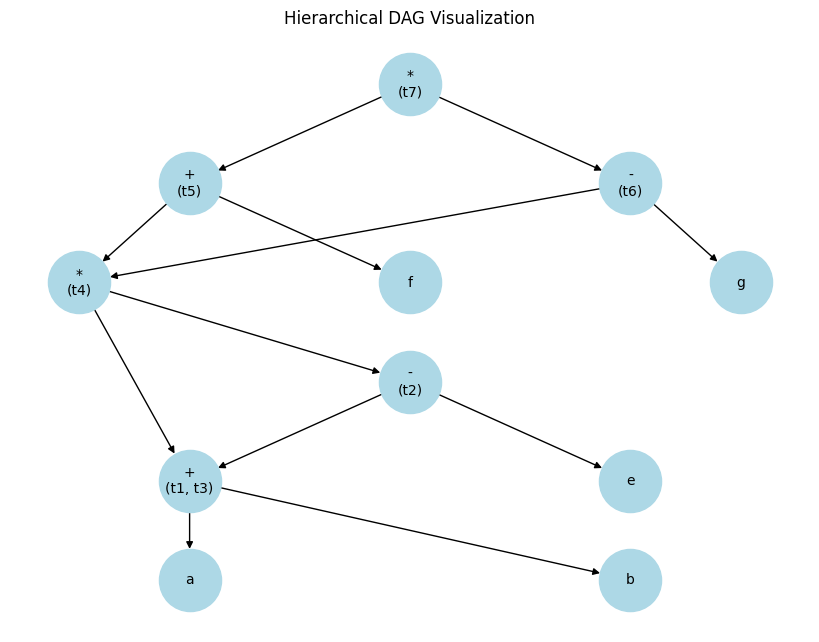


Optimal Sequence after Heuristic Ordering (Interior Nodes):
1. Node 10 -> op: '*', labels: ['t7']
2. Node 7 -> op: '+', labels: ['t5']
3. Node 9 -> op: '-', labels: ['t6']
4. Node 5 -> op: '*', labels: ['t4']
5. Node 4 -> op: '-', labels: ['t2']
6. Node 2 -> op: '+', labels: ['t1', 't3']

Final Sequence:
[['t1', 't3'], ['t2'], ['t4'], ['t6'], ['t5'], ['t7']]


In [ ]:
if __name__ == "__main__":
    instructions = [
        "t1 := a + b",
        "t2 := t1 - e",
        "t3 := a + b",
        "t4 := t2 * t3",
        "t5 := t4 + f",
        "t6 := t4 - g",
        "t7 := t5 * t6"
    ]

    dag = construct_dag_from_instructions(instructions)
    print("DAG Construction for Three-Address Code:")
    for idx, node in enumerate(dag):
        print(f"Node {idx}: op={node['op']}, left={node['left']}, right={node['right']}, labels={node['labels']}")

    visualize_dag(dag)

    ordering = node_listing()
    print("\nOptimal Sequence after Heuristic Ordering (Interior Nodes):")
    for i, node_idx in enumerate(ordering):
        node = nodes[node_idx]
        print(f"{i+1}. Node {node_idx} -> op: '{node['op']}', labels: {node['labels']}")

    print("\nFinal Sequence:")
    temp = list()
    for i, node_idx in enumerate(ordering):
        node = nodes[node_idx]
        temp.append(node['labels'])
    ans = temp[::-1]
    print(ans)

DAG Construction for Three-Address Code:
Node 0: op=None, left=None, right=None, labels=['4']
Node 1: op=None, left=None, right=None, labels=['i']
Node 2: op=*, left=0, right=1, labels=['t1', 't3']
Node 3: op=None, left=None, right=None, labels=['a']
Node 4: op=[], left=3, right=2, labels=['t2']
Node 5: op=None, left=None, right=None, labels=['b']
Node 6: op=[], left=5, right=2, labels=['t4']
Node 7: op=*, left=4, right=6, labels=['t5']


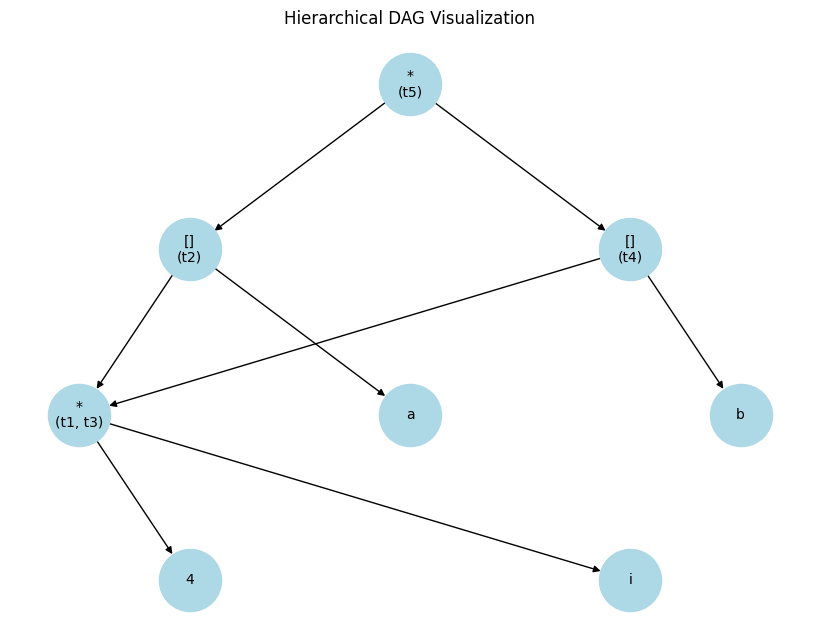


Optimal Sequence after Heuristic Ordering (Interior Nodes):
1. Node 7 -> op: '*', labels: ['t5']
2. Node 4 -> op: '[]', labels: ['t2']
3. Node 6 -> op: '[]', labels: ['t4']
4. Node 2 -> op: '*', labels: ['t1', 't3']

Final Sequence:
[['t1', 't3'], ['t4'], ['t2'], ['t5']]


In [ ]:
if __name__ == "__main__":
    instructions = [
         "t1 := 4 * i",
         "t2 := a[t1]",
         "t3 := 4 * i",
         "t4 := b[t3]",
         "t5 := t2 * t4"
   ]

    dag = construct_dag_from_instructions(instructions)
    print("DAG Construction for Three-Address Code:")
    for idx, node in enumerate(dag):
        print(f"Node {idx}: op={node['op']}, left={node['left']}, right={node['right']}, labels={node['labels']}")

    visualize_dag(dag)

    ordering = node_listing()
    print("\nOptimal Sequence after Heuristic Ordering (Interior Nodes):")
    for i, node_idx in enumerate(ordering):
        node = nodes[node_idx]
        print(f"{i+1}. Node {node_idx} -> op: '{node['op']}', labels: {node['labels']}")

    print("\nFinal Sequence:")
    temp = list()
    for i, node_idx in enumerate(ordering):
        node = nodes[node_idx]
        temp.append(node['labels'])
    ans = temp[::-1]
    print(ans)